In [88]:
import numpy as np
import cv2
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt
from datasets import Dataset
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import median
import torch
from torch.nn.functional import threshold, normalize

In [60]:
# We need to load all of the training images into a numpy array. One array for originals, and one for masks
original_filelist = glob.glob('../data_for_ml/original/*.png')
len(original_filelist)
original_filelist = sorted(original_filelist)
masked_filelist = glob.glob('../data_for_ml/masked/*.png')
masked_filelist = sorted(masked_filelist)
len(masked_filelist)

7200

In [61]:
original_filelist

['../data_for_ml/original/1.png',
 '../data_for_ml/original/10.png',
 '../data_for_ml/original/100.png',
 '../data_for_ml/original/1000.png',
 '../data_for_ml/original/1001.png',
 '../data_for_ml/original/1002.png',
 '../data_for_ml/original/1003.png',
 '../data_for_ml/original/1004.png',
 '../data_for_ml/original/1005.png',
 '../data_for_ml/original/1006.png',
 '../data_for_ml/original/1007.png',
 '../data_for_ml/original/1008.png',
 '../data_for_ml/original/1009.png',
 '../data_for_ml/original/101.png',
 '../data_for_ml/original/1010.png',
 '../data_for_ml/original/1011.png',
 '../data_for_ml/original/1012.png',
 '../data_for_ml/original/1013.png',
 '../data_for_ml/original/1014.png',
 '../data_for_ml/original/1015.png',
 '../data_for_ml/original/1016.png',
 '../data_for_ml/original/1017.png',
 '../data_for_ml/original/1018.png',
 '../data_for_ml/original/1019.png',
 '../data_for_ml/original/102.png',
 '../data_for_ml/original/1020.png',
 '../data_for_ml/original/1021.png',
 '../data

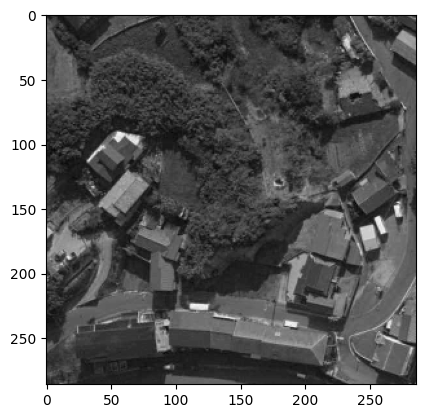

In [36]:
image_one = np.array(Image.open(original_filelist[0]))
gray_image_one = np.mean(image_one, axis=-1)
plt.imshow(gray_image_one, cmap='gray')

In [62]:
# This will work to read in everything into a numpy array, but
# it throws an error due to differing pic sizes
# for now, let's try excluding the larger 572 pixel images
original_images_array = np.array([np.asarray((Image.open(fname))) for fname in original_filelist if '-' not in fname])
original_images_array.shape

(6000, 286, 286, 3)

In [63]:
# Now let's do the same for the masks, again ignoring the 572 sized images
# We we will need to change this to the black and white images
masks_array = np.array([np.asarray((Image.open(fname))) for fname in masked_filelist if '-' not in fname])
masks_array.shape

(6000, 286, 286, 3)

# We may need to delete any images which have no masks in them. I can't do it yet without the black and white images

In [ ]:
# ### drop empty images here###
# # Create a list to store the indices of non-empty masks
# valid_indices = [i for i, mask in enumerate(masks_array) if mask.max() != 0]
# # Filter the image and mask arrays to keep only the non-empty pairs
# filtered_images = original_images_array[valid_indices]
# filtered_masks = masks_array[valid_indices]
# print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
# print("Mask shape:", filtered_masks.shape)

# Create a dataset object that will serve us input images and masks for the rest of the training

In [66]:
# Convert the NumPy arrays to pillow images and store them in a dictionary
dataset_dict = {
    'image': [Image.fromarray(img) for img in original_images_array],
    'label': [Image.fromarray(mask) for mask in masks_array]
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [67]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 6000
})

Let's check to make sure our images and masks are loading correctly.

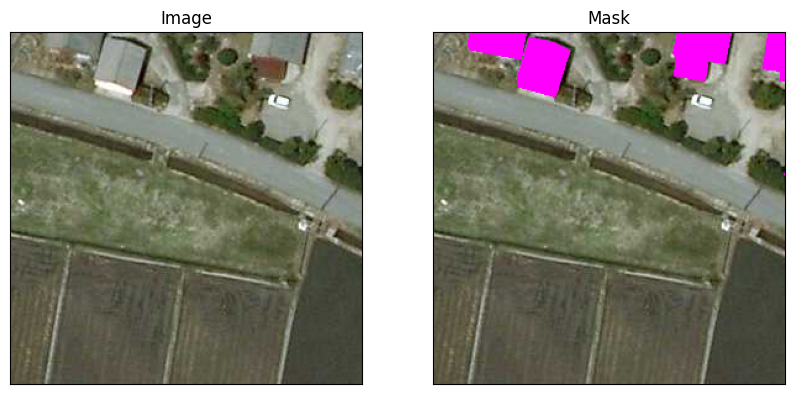

In [69]:
img_num = random.randint(0, original_images_array.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Next, we need to get bounding boxes from masks.

In [70]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [73]:

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [74]:
# Initalize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json: 100%|██████████| 466/466 [00:00<00:00, 949kB/s]


In [75]:
# Create an instance of the SAM Dataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# I think the only reason the below error is showing up is because the masks are not black and white yet

In [79]:
train_dataset[0]

ValueError: too many values to unpack (expected 2)

In [77]:
example = train_dataset[0]
example.items()
#for k,v in example.items():
  #print(k,v.shape)

ValueError: too many values to unpack (expected 2)

In [81]:
# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [82]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

ValueError: too many values to unpack (expected 2)

In [83]:
batch["ground_truth_mask"].shape

NameError: name 'batch' is not defined

In [84]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained('facebook/sam-vit-base')

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith('vision_encoder') or name.startswith('prompt_encoder'):
        param.requires_grad_(False)

config.json: 100%|██████████| 6.57k/6.57k [00:00<00:00, 8.51MB/s]
model.safetensors: 100%|██████████| 375M/375M [00:17<00:00, 21.6MB/s] 


In [87]:
# initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# The following can only be done once we have the black and white masks!!

In [ ]:
#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_model_checkpoint.pth")

# The next step will be to load in our saved model and see how it does...